In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt
import math
from statistics import mean
from statistics import stdev
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

# Imports

In [31]:
petition_df = pd.read_csv("~/data/sf-open-data/petitions-clean.csv") # 40749 rows
petition_df['Datetime'] = petition_df['Date'].apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y"))
petition_df['Timestamp'] = petition_df['Date'].apply(lambda x : mdates.datestr2num(x))

# Neighborhood Number

In [32]:
# Collect all count results

petition_counts_by_neighborhood_df = petition_df[petition_df['Neighborhood Number'] == 1] \
    [['Petition ID Len', 'Datetime']] \
    .groupby(pd.TimeGrouper("M", key="Datetime")).count().rename(columns = {"Petition ID Len": 1})

for i in range(2, 27):
    petition_counts_by_neighborhood_df[i] = petition_df[petition_df['Neighborhood Number'] == i] \
        [['Petition ID Len', 'Datetime']] \
        .groupby(pd.TimeGrouper("M", key="Datetime")).count().fillna(0)
    
for i in range(28, 42):
    petition_counts_by_neighborhood_df[i] = petition_df[petition_df['Neighborhood Number'] == i] \
        [['Petition ID Len', 'Datetime']] \
        .groupby(pd.TimeGrouper("M", key="Datetime")).count().fillna(0)
    
petition_counts_by_neighborhood_df

,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
Datetime,,,,,,,,,,,,,,,,,,,,,
1997-01-31,2,5,6,NaN,6,NaN,1,1,7,NaN,...,6,NaN,1.0,5,13,NaN,2,7,NaN,1
1997-02-28,2,5,3,NaN,8,NaN,3,0,8,1.0,...,7,NaN,2.0,3,8,NaN,0,2,2.0,3
1997-03-31,5,6,10,NaN,12,NaN,3,1,13,0.0,...,4,NaN,2.0,11,6,NaN,4,5,1.0,3
1997-04-30,3,3,6,NaN,10,2.0,2,1,3,2.0,...,3,NaN,2.0,7,14,NaN,4,1,0.0,4
1997-05-31,1,5,7,NaN,6,1.0,5,0,10,0.0,...,5,NaN,2.0,9,8,NaN,3,1,3.0,1
1997-06-30,4,7,5,NaN,4,0.0,2,0,12,1.0,...,5,NaN,1.0,7,17,NaN,6,6,2.0,3
1997-07-31,1,7,6,NaN,8,0.0,5,0,9,2.0,...,9,NaN,3.0,6,11,NaN,4,4,1.0,0
1997-08-31,3,6,7,NaN,17,4.0,3,2,11,1.0,...,6,NaN,6.0,8,5,NaN,0,1,1.0,1
1997-09-30,2,4,9,NaN,12,2.0,6,2,9,1.0,...,6,NaN,0.0,12,8,NaN,1,4,1.0,6


In [33]:
seasonal_neighborhoods_list = petition_counts_by_neighborhood_df.dropna(axis = 1).drop(columns = [8, 21, 24, 38, 41]).columns
stationary_neighborhoods_list = sorted(list(set(petition_counts_by_neighborhood_df.columns).difference(set(seasonal_neighborhoods_list))))
na_neighborhoods_list = sorted(list(set(petition_counts_by_neighborhood_df.columns).difference(set(petition_counts_by_neighborhood_df.dropna(axis = 1)))))

# Seasonal Decomp

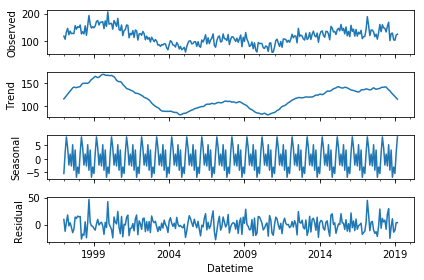

In [34]:
petition_decomp = seasonal_decompose(petition_counts_by_neighborhood_df[seasonal_neighborhoods_list].sum(axis=1), model='additive', extrapolate_trend = True)
petition_decomp.plot();

In [35]:
# Petition Decomp
petition_decomp_df = pd.DataFrame(petition_decomp.observed).reset_index().rename(columns = {0: 'Observed'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.trend.reset_index(), on = ['Datetime']).rename(columns = {0: 'Trend'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.seasonal.reset_index(), on = ['Datetime']).rename(columns = {0: 'Seasonal'})
petition_decomp_df = petition_decomp_df.merge(petition_decomp.resid.reset_index(), on = ['Datetime']).rename(columns = {0: 'Resid'})
petition_decomp_df['Sum'] = petition_decomp_df['Trend'] + petition_decomp_df['Seasonal'] + petition_decomp_df['Resid']

seasonal_min = min(petition_decomp_df['Seasonal'])
petition_decomp_df['Adj. Trend'] = petition_decomp_df['Trend'] + seasonal_min
petition_decomp_df['Adj. Seasonal'] = petition_decomp_df['Seasonal'] - seasonal_min
petition_decomp_df['Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid']
petition_decomp_df['Adj. Signal'] = petition_decomp_df['Trend'] + petition_decomp_df['Resid'] + seasonal_min 

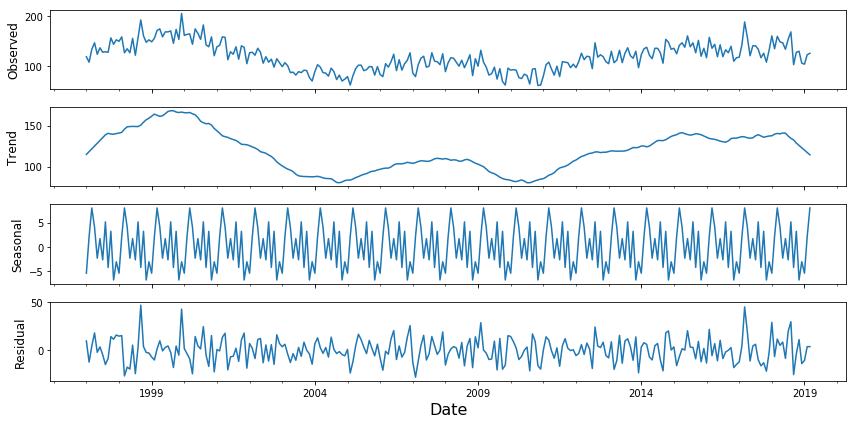

In [36]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,6))
petition_decomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed', fontsize = 12)
petition_decomp.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend', fontsize = 12)
petition_decomp.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal', fontsize = 12)
petition_decomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual', fontsize = 12)
axes[3].set_xlabel('Date', fontsize = 16)
plt.tight_layout()
#plt.savefig('figures/seasonal-decomp.png', transparent = True, bbox_inches = 'tight')
plt.show()

# Autocorrelation Plots

In [63]:
petition_train_df = petition_decomp_df[['Datetime', 'Adj. Trend']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_df = petition_decomp_df[['Datetime', 'Adj. Trend']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]

In [64]:
petition_train_df['Diff'] = petition_train_df.apply(lambda x: x.diff(periods = 1))['Adj. Trend']
petition_train_df['Diff2'] = petition_train_df.apply(lambda x: x.diff(periods = 1))['Diff']

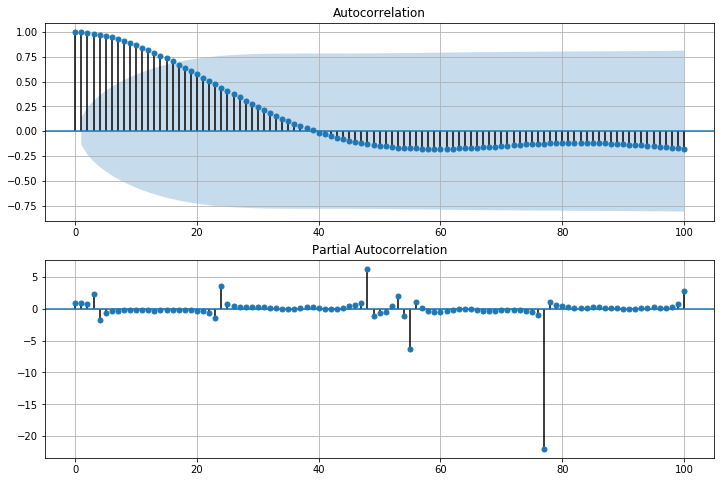

In [65]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(petition_train_df[['Datetime', 'Adj. Trend']].set_index('Datetime'), lags=100, ax=ax1)
plt.grid(True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(petition_train_df[['Datetime', 'Adj. Trend']].set_index('Datetime'), lags=100, ax=ax2)
plt.grid(True)
plt.savefig("figures/sarima/acf-pacf.png", transparent = True, bbox_inches = 'tight')
plt.show()

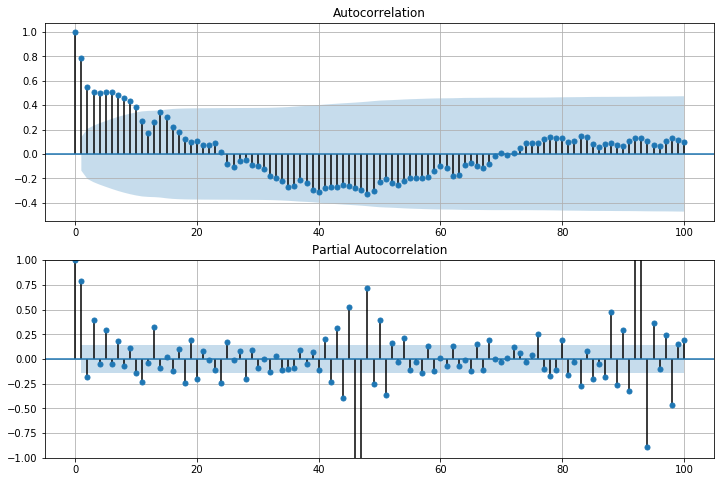

In [67]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plt.grid(True)
fig = sm.graphics.tsa.plot_acf(petition_train_df[['Datetime', 'Diff']].set_index('Datetime').dropna(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(petition_train_df[['Datetime', 'Diff']].set_index('Datetime').dropna(), lags=100, ax=ax2)
plt.grid(True)
plt.ylim(-1, 1)
plt.savefig("figures/sarima/acf-pacf-diff.png", transparent = True, bbox_inches = 'tight')
plt.show()

# Forecasting Petitions Directly on Signal

In [130]:
# Split data
petition_train_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_df = petition_decomp_df[['Datetime', 'Adj. Signal']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]

Text(0.5,1,'Train-Test Split')

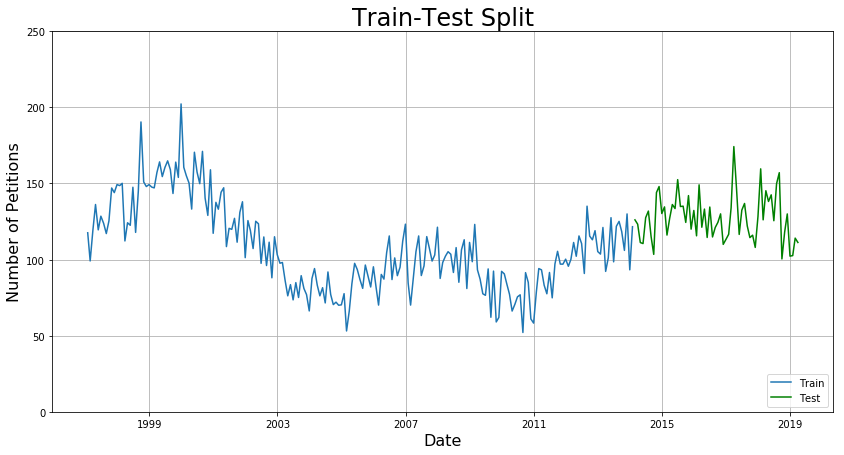

In [70]:
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(petition_train_df[['Datetime', 'Adj. Signal']].set_index("Datetime"), label = 'Train')
plt.plot(petition_test_df[['Datetime', 'Adj. Signal']].set_index("Datetime"), label = 'Test', color = 'g')
plt.ylim(0, 250)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Petitions', fontsize=16)
plt.legend(loc = 'lower right')
ax.grid(True)
plt.title('Train-Test Split', fontsize=24)
#plt.savefig("figures/sarima/train-test-split.png", transparent=True, bbox_inches="tight")

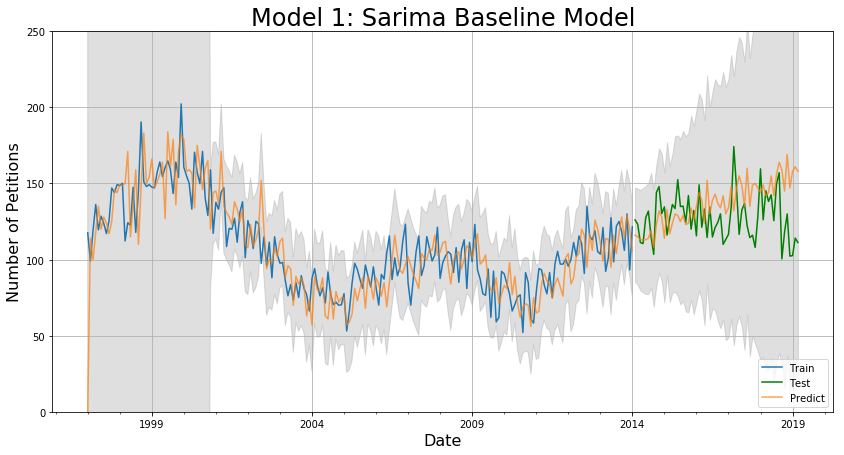

In [224]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['Datetime', 'Adj. Signal']].set_index("Datetime"),
                                order=(1, 1, 1),
                                seasonal_order=(2, 1, 0, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               freq = 'M')

results = mod.fit()

# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

# Plotting
ax = petition_train_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Train'}).set_index("Datetime").plot(figsize=(14, 7))
petition_test_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Test'}).set_index("Datetime").plot(ax=ax, color = 'g')
train.predicted_mean.round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index, train_ci.iloc[:, 0], train_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
test.predicted_mean.round().plot(ax=ax, label = '_nolegend_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index, test_ci.iloc[:, 0], test_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Petitions', fontsize = 16)
plt.legend(loc='lower right')
plt.ylim(0, 250)
ax.grid(True)
plt.title('Model 1: Sarima Baseline Model', fontsize=24)

plt.savefig('figures/sarima/sarima-baseline-model', transparent = True, bbox_inches="tight")

In [221]:
# MAE for 3 months after the train
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['Datetime', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index("Datetime")['Observed'])[0:4]
    ))

5.658082180500628

In [222]:
# MAE for 3 months after the train
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['Datetime', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index("Datetime")['Observed'])[0:13]
    ))

10.793946995033943

In [223]:
# MAE for entire test set
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['Datetime', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index("Datetime")['Observed'])
    ))

18.398965106889367

Text(0.5,1,'Model 1: Sarima Baseline Model')

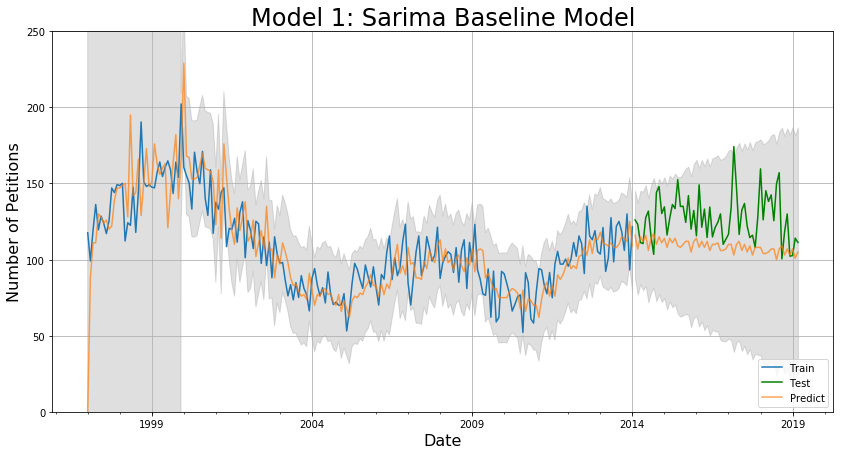

In [71]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['Datetime', 'Adj. Signal']].set_index("Datetime"),
                                order=(2, 1, 2),
                                seasonal_order=(0, 1, 2, 16),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               freq = 'M')

results = mod.fit()

# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

# Plotting
ax = petition_train_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Train'}).set_index("Datetime").plot(figsize=(14, 7))
petition_test_df[['Datetime', 'Adj. Signal']].rename(columns = {'Adj. Signal': 'Test'}).set_index("Datetime").plot(ax=ax, color = 'g')
train.predicted_mean.round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index, train_ci.iloc[:, 0], train_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
test.predicted_mean.round().plot(ax=ax, label = '_nolegend_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index, test_ci.iloc[:, 0], test_ci.iloc[:, 1], color='grey', alpha=.25) # Confidence Interval
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Petitions', fontsize = 16)
plt.legend(loc='lower right')
plt.ylim(0, 250)
ax.grid(True)
plt.title('Model 1: Sarima Baseline Model', fontsize=24)

#plt.savefig('figures/sarima/sarima-baseline-model', transparent = True, bbox_inches="tight")

In [20]:
# MAE for 3 months after the train
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['Datetime', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index("Datetime")['Observed'])[0:4]
    ))

8.408082180500628

In [21]:
# MAE for entire test set
mean(abs(
    (pd.DataFrame(test.predicted_mean.round())[0]
         - petition_test_df[['Datetime', 'Adj. Signal']] \
         .rename(columns = {'Adj. Signal': 'Observed'}) \
         .set_index("Datetime")['Observed'])
    ))

17.580578753878196

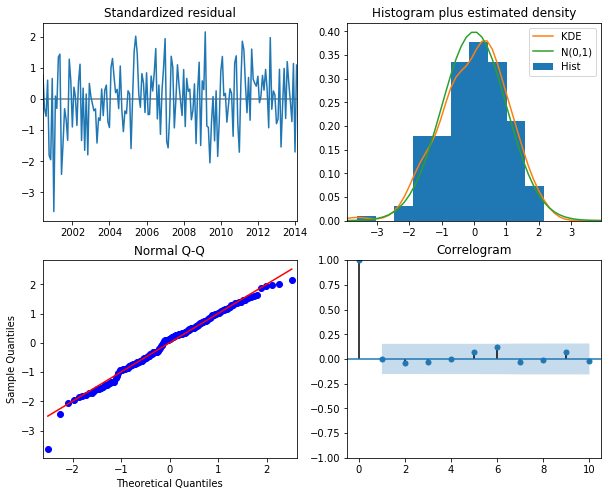

In [22]:
# Diagnostic Plots
results.plot_diagnostics(figsize=(10, 8));

# Forecasting Petitions on Trend

In [112]:
# Split data
petition_train_df = petition_decomp_df[['Datetime', 'Adj. Trend']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_df = petition_decomp_df[['Datetime', 'Adj. Trend']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]
petition_train_seasonal_df = petition_decomp_df[['Datetime', 'Adj. Seasonal']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_seasonal_df = petition_decomp_df[['Datetime', 'Adj. Seasonal']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]
petition_train_resid_df = petition_decomp_df[['Datetime', 'Resid']][petition_decomp_df['Datetime'] <= dt.datetime(2014, 1, 31)]
petition_test_resid_df = petition_decomp_df[['Datetime', 'Resid']][petition_decomp_df['Datetime'] > dt.datetime(2014, 1, 31)]

In [83]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['Datetime', 'Adj. Trend']].set_index("Datetime"),
                                order=(2, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               freq = 'M')

results = mod.fit()

Text(0.5,1,'Model 2: Sarima Model on Trend')

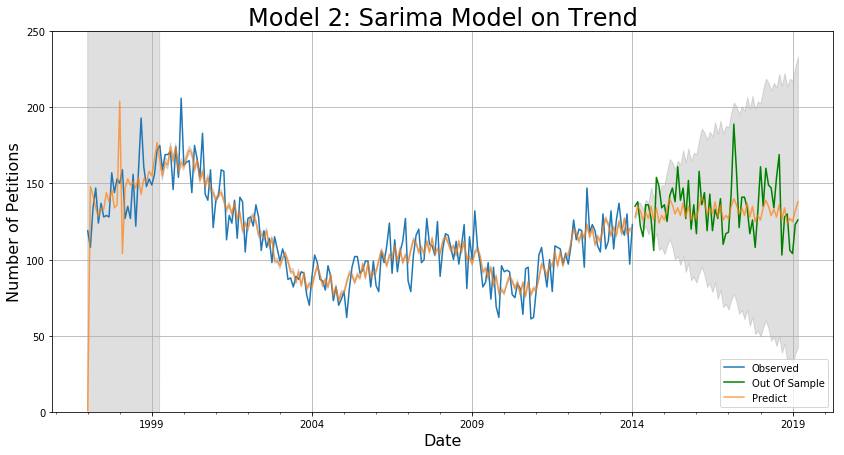

In [84]:
# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

petition_train_df['Adj. Predict'] = petition_train_df['Adj. Trend'] + petition_train_seasonal_df['Adj. Seasonal'] + petition_train_resid_df['Resid']
petition_test_df['Adj. Predict'] = petition_test_df['Adj. Trend'] + petition_test_seasonal_df['Adj. Seasonal'] + petition_test_resid_df['Resid']

# Plotting
ax = petition_train_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Observed'}) \
    .set_index("Datetime").plot(figsize=(14, 7)) # Add actual data
petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
    .set_index("Datetime").plot(ax=ax, color = 'g')
(train.predicted_mean + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
    .round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index,
                train_ci.iloc[:, 0] + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal'],
                train_ci.iloc[:, 1] + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal'],
                color='grey', alpha=.25)
(test.predicted_mean + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
    .plot(ax=ax, label='_nolabel_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index,
                (test_ci.iloc[:, 0] + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']),
                (test_ci.iloc[:, 1] + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']),
                color='grey', alpha=.25)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Petitions', fontsize = 16)
plt.legend(loc='lower right')
plt.ylim(0, 250)
ax.grid(True)
plt.title('Model 2: Sarima Model on Trend', fontsize=24)

#plt.savefig('Figures/Forecasted Number of Petitions 2', transparent = True, bbox_inches="tight")

In [85]:
# MAE for 3 months
mean(abs(
    ((test.predicted_mean \
      + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
      - petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
      .set_index("Datetime")['Out Of Sample'])[0:4]
    ))

7.750000000000007

In [86]:
# MAE for 5 years
mean(abs(
    ((test.predicted_mean \
      + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
      - petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
      .set_index("Datetime")['Out Of Sample'])
    ))

12.258064516129034

In [125]:
mod = sm.tsa.statespace.SARIMAX(petition_train_df[['Datetime', 'Adj. Trend']].set_index("Datetime"),
                                order=(2, 1, 0),
                                seasonal_order=(0, 1, 2, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                               freq = 'M')

results = mod.fit()

Text(0.5,1,'Model 2: Sarima Model on Trend')

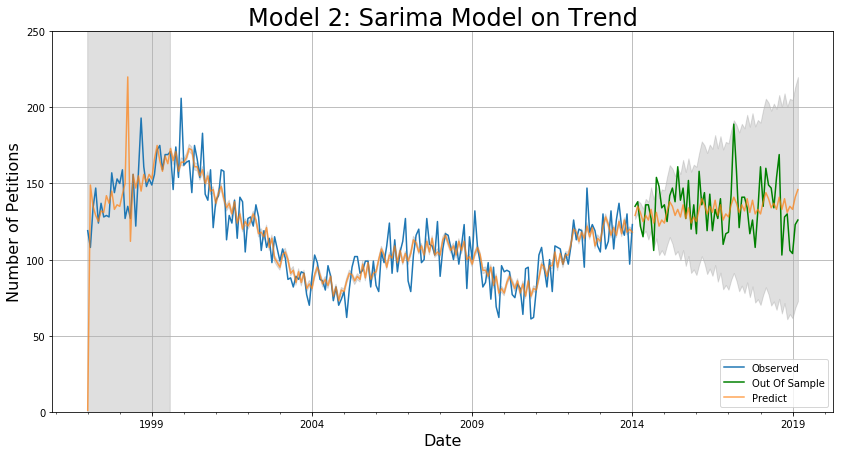

In [126]:
# Results
train = results.get_prediction(start=pd.to_datetime('1997-1-31'), end = pd.to_datetime('2014-1-31'), dynamic=False)
train_ci = train.conf_int()
test = results.get_prediction(start=pd.to_datetime('2014-2-28'), end = pd.to_datetime('2019-03-31'), dynamic=False)
test_ci = test.conf_int()

petition_train_df['Adj. Predict'] = petition_train_df['Adj. Trend'] + petition_train_seasonal_df['Adj. Seasonal'] + petition_train_resid_df['Resid']
petition_test_df['Adj. Predict'] = petition_test_df['Adj. Trend'] + petition_test_seasonal_df['Adj. Seasonal'] + petition_test_resid_df['Resid']

# Plotting
ax = petition_train_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Observed'}) \
    .set_index("Datetime").plot(figsize=(14, 7)) # Add actual data
petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
    .set_index("Datetime").plot(ax=ax, color = 'g')
(train.predicted_mean + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
    .round().plot(ax=ax, label='Predict', alpha=.7, color = '#ff7f0e') # Add train data
ax.fill_between(train_ci.index,
                train_ci.iloc[:, 0] + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal'],
                train_ci.iloc[:, 1] + petition_train_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal'],
                color='grey', alpha=.25)
(test.predicted_mean + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
    .plot(ax=ax, label='_nolabel_', alpha=.7, color = '#ff7f0e') # Add test data
ax.fill_between(test_ci.index,
                (test_ci.iloc[:, 0] + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']),
                (test_ci.iloc[:, 1] + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']),
                color='grey', alpha=.25)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Petitions', fontsize = 16)
plt.legend(loc='lower right')
plt.ylim(0, 250)
ax.grid(True)
plt.title('Model 2: Sarima Model on Trend', fontsize=24)

#plt.savefig('Figures/Forecasted Number of Petitions 2', transparent = True, bbox_inches="tight")

In [127]:
# MAE for 3 months
mean(abs(
    ((test.predicted_mean \
      + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
      - petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
      .set_index("Datetime")['Out Of Sample'])[0:4]
    ))

7.000000000000007

In [128]:
# MAE for 5 years
mean(abs(
    ((test.predicted_mean \
      + petition_test_seasonal_df[['Datetime', 'Adj. Seasonal']].set_index('Datetime')['Adj. Seasonal']).round() \
      - petition_test_df[['Datetime', 'Adj. Predict']].rename(columns = {'Adj. Predict': 'Out Of Sample'}) \
      .set_index("Datetime")['Out Of Sample'])
    ))

12.838709677419356

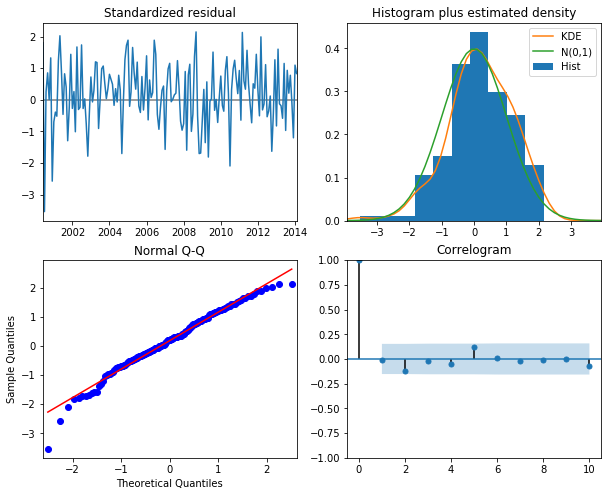

In [32]:
# Diagnostic Plots
results.plot_diagnostics(figsize=(10, 8));